In [1]:
import pandas as pd
import seaborn as sns
from keras import models
from keras import optimizers
from keras.layers import Dense, Dropout
import keras.backend as K
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
data = pd.read_csv("train.csv")

In [3]:
data.head(10)

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
5,mlm,4f5f3743,2020-06-11T09:12:37,Peggy,Добавлено больше логирования и фикс до частичн...,6
6,mlm,24a11c40,2020-06-10T15:34:22,Victor,"Отладка, чтоб оно хотябы запускалось",4
7,mlm,3287c74a,2020-06-10T15:34:04,Victor,Добавил скрипт для запуска контейнера,4
8,mlm,c78d5187,2020-06-10T15:22:21,Victor,label не нужен,2
9,mlm,bcb47e60,2020-06-10T14:54:14,Victor,Установка всех зависимостей теперь в докер файле,5


In [4]:
data.shape

(319, 6)

In [6]:
data.isna().sum()

repository_name    0
commit_hash        0
commit_date        0
commit_author      0
commit_message     0
bugs               0
dtype: int64

In [7]:
authors = set(i for i in data["commit_author"])

In [8]:
authors

{'Alice',
 'Bob',
 'Carol',
 'Dabe',
 'Eve',
 'Mallory',
 'Peggy',
 'Trudy',
 'Victor',
 'Wendy'}

In [11]:
authors_index = dict(zip(list(set(i for i in data["commit_author"])), [i for i in range(len(set(i for i in data["commit_author"])))]))

In [12]:
authors

{'Victor': 0,
 'Eve': 1,
 'Wendy': 2,
 'Bob': 3,
 'Dabe': 4,
 'Mallory': 5,
 'Trudy': 6,
 'Carol': 7,
 'Alice': 8,
 'Peggy': 9}

In [15]:
authors_counts = dict(zip(list(authors), [data[data['commit_author'] == i].shape[0] for i in authors]))

In [17]:
authors_counts

{'Victor': 134,
 'Eve': 9,
 'Wendy': 48,
 'Bob': 2,
 'Dabe': 42,
 'Mallory': 67,
 'Trudy': 9,
 'Carol': 4,
 'Alice': 2,
 'Peggy': 2}

In [18]:
Alice = data[data["commit_author"] == "Alice"]

In [19]:
Alice

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
282,sensor,5f540152,2020-04-09T11:46:33,Alice,bug fixes,0
283,sensor,683d099a,2020-04-09T10:40:31,Alice,add ntp honeypot,1


In [20]:
Carol = data[data["commit_author"] == "Carol"]
Carol

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
201,dockers,2ac5f8a8,2020-06-02T13:35:06,Carol,"ciscoasa_v2: add logging, file.log -> file.jso...",0
203,dockers,363ec636,2020-05-29T12:04:24,Carol,fatt_v2: pyshark memory leak problem solved,2
205,dockers,e28c92d3,2020-05-24T16:27:18,Carol,kako_v2: -you can change active simulations wi...,4
207,dockers,6e32133b,2020-05-20T21:25:51,Carol,"KAKO: kako.json,kako.log; NTP: ntp_logs.json; ...",0


In [47]:
repos = set(i for i in data["repository_name"])
repos = list(repos)
repos = dict(zip(repos, [i for i in range(len(repos))]))

In [23]:
data.repository_name = data.repository_name.apply(prepare)

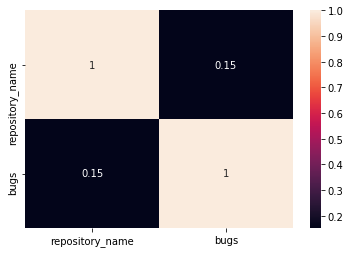

In [24]:
sns.heatmap(data.corr(), annot = True) # по матрице корреляции видно, что имя репозитория не влияет на target

In [25]:
%matplotlib inline

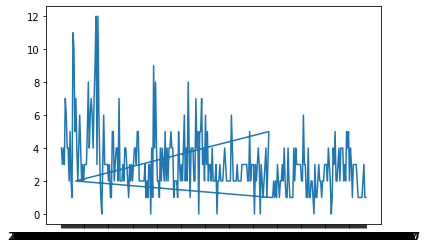

In [26]:
# зависимость target от даты коммита есть, но если смотреть по линии тренда
plt.plot(data["commit_date"], data["bugs"])

In [27]:
# TfidVectorizer нужен для токенизации слов в коммитах в зависимости от их частоты и соответсвенно важности
from sklearn.feature_extraction.text import TfidfVectorizer
idf_vectorizer = TfidfVectorizer()

In [28]:
commits = [i for i in data["commit_message"]]

In [29]:
commits

['объяснения предсказаний с помощью lime',
 'Поставил lime вместо eli5',
 'Скрипт для создния пакетов обновления',
 'Сортировка весов по убыванию',
 'не надо конвертировать массив до операции по смене знака',
 'Добавлено больше логирования и фикс до частичной работоспособности',
 'Отладка, чтоб оно хотябы запускалось',
 'Добавил скрипт для запуска контейнера',
 'label не нужен',
 'Установка всех зависимостей теперь в докер файле',
 'Использование sha256',
 'Обновление схем',
 'Не сохранять неизвестные поля, на них нельзя обучаться и поэтому нет смысла их хранить',
 'hdf5 не умеет хранить матрицы различных типов, сделал группу с хешами, а в...',
 'Скрипт для создания датасета из csv файла',
 'тип и всякие статичные данные пусть лежат в датасете',
 'eli5 предсказание для бинарных классификаторов',
 'Функции проверки меток',
 'Апи для моделей и датасетов',
 'Пересмотрели архитектуру, теперь все запросы через http',
 'Перешли с npz на hdf5',
 'добавил aiohttp',
 'Диаграмы процессов и архит

In [97]:
# обучение токенизатора
Y = idf_vectorizer.fit_transform(commits)
print(idf_vectorizer.vocabulary_)

{'объяснения': 549, 'предсказаний': 601, 'помощью': 589, 'lime': 197, 'поставил': 593, 'вместо': 419, 'eli5': 110, 'скрипт': 629, 'для': 443, 'создния': 638, 'пакетов': 566, 'обновления': 543, 'сортировка': 640, 'весов': 417, 'по': 578, 'убыванию': 670, 'не': 527, 'надо': 523, 'конвертировать': 502, 'массив': 514, 'до': 444, 'операции': 554, 'смене': 633, 'знака': 471, 'добавлено': 448, 'больше': 410, 'логирования': 512, 'фикс': 685, 'частичной': 696, 'работоспособности': 614, 'отладка': 559, 'чтоб': 699, 'оно': 553, 'хотябы': 692, 'запускалось': 469, 'добавил': 445, 'запуска': 468, 'контейнера': 503, 'label': 192, 'нужен': 534, 'установка': 678, 'всех': 425, 'зависимостей': 462, 'теперь': 658, 'докер': 450, 'файле': 683, 'использование': 489, 'sha256': 326, 'обновление': 540, 'схем': 656, 'сохранять': 642, 'неизвестные': 529, 'поля': 587, 'на': 522, 'них': 532, 'нельзя': 530, 'обучаться': 548, 'поэтому': 595, 'hdf5': 158, 'умеет': 674, 'хранить': 693, 'матрицы': 515, 'различных': 616,

In [31]:
'''
средняя длина одного комментария примерно 10 слов, соответсвенно обрезаем все комментарии по 10 слов
если слов не хватает, то заполняем нулями, посколько в пространстве 0 означает, что этот параметр в прямом смысле
"параллелен" опорным векторам, разделяющих данные
'''
print(np.max([len(i.split()) for i in commits]) * 0.7)

9.799999999999999


In [32]:
for i in range(len(commits)):
    if len(commits[i].split()) > 10:
        commits[i] = " ".join(commits[i].split()[0:10])

In [33]:
commits

['объяснения предсказаний с помощью lime',
 'Поставил lime вместо eli5',
 'Скрипт для создния пакетов обновления',
 'Сортировка весов по убыванию',
 'не надо конвертировать массив до операции по смене знака',
 'Добавлено больше логирования и фикс до частичной работоспособности',
 'Отладка, чтоб оно хотябы запускалось',
 'Добавил скрипт для запуска контейнера',
 'label не нужен',
 'Установка всех зависимостей теперь в докер файле',
 'Использование sha256',
 'Обновление схем',
 'Не сохранять неизвестные поля, на них нельзя обучаться и поэтому',
 'hdf5 не умеет хранить матрицы различных типов, сделал группу с',
 'Скрипт для создания датасета из csv файла',
 'тип и всякие статичные данные пусть лежат в датасете',
 'eli5 предсказание для бинарных классификаторов',
 'Функции проверки меток',
 'Апи для моделей и датасетов',
 'Пересмотрели архитектуру, теперь все запросы через http',
 'Перешли с npz на hdf5',
 'добавил aiohttp',
 'Диаграмы процессов и архитектуры',
 'Оптимизировал докер файл',

In [34]:
np.max([len(i.split()) for i in commits])

10

In [35]:
# сама токенизация
commits_index = list()
for i in range(len(commits)):
    tmp = []
    for j in commits[i].split():
        try:
            tmp.append(idf_vectorizer.vocabulary_[j])
        except:
            ;
    while len(tmp) < 10:
        tmp.append(0)
#     print(len(tmp))
    commits_index.append(tmp)
commits_index

[[552, 604, 592, 197, 0, 0, 0, 0, 0, 0],
 [197, 419, 110, 0, 0, 0, 0, 0, 0, 0],
 [443, 642, 569, 546, 0, 0, 0, 0, 0, 0],
 [417, 581, 674, 0, 0, 0, 0, 0, 0, 0],
 [529, 525, 503, 516, 444, 557, 581, 636, 471, 0],
 [410, 514, 689, 444, 701, 617, 0, 0, 0, 0],
 [704, 556, 697, 469, 0, 0, 0, 0, 0, 0],
 [632, 443, 468, 504, 0, 0, 0, 0, 0, 0],
 [192, 529, 537, 0, 0, 0, 0, 0, 0, 0],
 [425, 462, 662, 450, 687, 0, 0, 0, 0, 0],
 [326, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [660, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [646, 531, 524, 535, 532, 551, 598, 0, 0, 0],
 [158, 529, 678, 698, 517, 619, 625, 432, 0, 0],
 [443, 641, 435, 473, 79, 686, 0, 0, 0, 0],
 [665, 426, 654, 434, 616, 511, 436, 0, 0, 0],
 [110, 603, 443, 408, 493, 0, 0, 0, 0, 0],
 [609, 520, 0, 0, 0, 0, 0, 0, 0, 0],
 [443, 521, 437, 0, 0, 0, 0, 0, 0, 0],
 [662, 423, 467, 703, 165, 0, 0, 0, 0, 0],
 [237, 524, 158, 0, 0, 0, 0, 0, 0, 0],
 [445, 15, 0, 0, 0, 0, 0, 0, 0, 0],
 [614, 405, 0, 0, 0, 0, 0, 0, 0, 0],
 [450, 685, 0, 0, 0, 0, 0, 0, 0, 0],
 [200, 170, 

In [36]:
len(commits_index)

319

In [37]:
data_prepare = data

In [38]:
data_prepare

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,2,b28abb42,2020-06-12T14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,2,438b5c4d,2020-06-12T11:53:10,Victor,Поставил lime вместо eli5,3
2,2,8e6e4f31,2020-06-11T15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,2,5e0956a6,2020-06-11T10:42:29,Victor,Сортировка весов по убыванию,3
4,2,b9f4b40c,2020-06-11T09:25:19,Victor,не надо конвертировать массив до операции по с...,7
...,...,...,...,...,...,...
314,0,5b1ecbcd,2020-03-23T12:54:35,Dabe,setting hostname,1
315,0,a3f5b753,2020-03-23T12:30:52,Dabe,heralding default dockerfile,2
316,0,e8155942,2020-03-23T11:27:40,Dabe,unnesserity /data path permissions setting,3
317,0,e748af51,2020-03-23T11:20:50,Dabe,added trapconductor,1


In [98]:
for i in range(data_prepare.shape[0]):
    data_prepare["commit_message"][i] = commits_index[i]
data_prepare

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,2,b28abb42,2020-06-12T14:26:12,Victor,"[552, 604, 592, 197, 0, 0, 0, 0, 0, 0]",4
1,2,438b5c4d,2020-06-12T11:53:10,Victor,"[197, 419, 110, 0, 0, 0, 0, 0, 0, 0]",3
2,2,8e6e4f31,2020-06-11T15:19:03,Victor,"[443, 642, 569, 546, 0, 0, 0, 0, 0, 0]",4
3,2,5e0956a6,2020-06-11T10:42:29,Victor,"[417, 581, 674, 0, 0, 0, 0, 0, 0, 0]",3
4,2,b9f4b40c,2020-06-11T09:25:19,Victor,"[529, 525, 503, 516, 444, 557, 581, 636, 471, 0]",7
...,...,...,...,...,...,...
314,0,5b1ecbcd,2020-03-23T12:54:35,Dabe,"[324, 164, 0, 0, 0, 0, 0, 0, 0, 0]",1
315,0,a3f5b753,2020-03-23T12:30:52,Dabe,"[161, 86, 100, 0, 0, 0, 0, 0, 0, 0]",2
316,0,e8155942,2020-03-23T11:27:40,Dabe,"[370, 254, 259, 324, 0, 0, 0, 0, 0, 0]",3
317,0,e748af51,2020-03-23T11:20:50,Dabe,"[12, 361, 0, 0, 0, 0, 0, 0, 0, 0]",1


In [40]:
data_prepare

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,2,b28abb42,2020-06-12T14:26:12,Victor,"[552, 604, 592, 197, 0, 0, 0, 0, 0, 0]",4
1,2,438b5c4d,2020-06-12T11:53:10,Victor,"[197, 419, 110, 0, 0, 0, 0, 0, 0, 0]",3
2,2,8e6e4f31,2020-06-11T15:19:03,Victor,"[443, 642, 569, 546, 0, 0, 0, 0, 0, 0]",4
3,2,5e0956a6,2020-06-11T10:42:29,Victor,"[417, 581, 674, 0, 0, 0, 0, 0, 0, 0]",3
4,2,b9f4b40c,2020-06-11T09:25:19,Victor,"[529, 525, 503, 516, 444, 557, 581, 636, 471, 0]",7
...,...,...,...,...,...,...
314,0,5b1ecbcd,2020-03-23T12:54:35,Dabe,"[324, 164, 0, 0, 0, 0, 0, 0, 0, 0]",1
315,0,a3f5b753,2020-03-23T12:30:52,Dabe,"[161, 86, 100, 0, 0, 0, 0, 0, 0, 0]",2
316,0,e8155942,2020-03-23T11:27:40,Dabe,"[370, 254, 259, 324, 0, 0, 0, 0, 0, 0]",3
317,0,e748af51,2020-03-23T11:20:50,Dabe,"[12, 361, 0, 0, 0, 0, 0, 0, 0, 0]",1


In [86]:
# подготовка данных для подачи в нейросеть
def prepare(data):
    
    data_prepare = data
    
    def prepare_repos(i):
        return repos[i]
    
#     repos = set(i for i in data_prepare["repository_name"])
#     repos = list(repos)
#     repos = dict(zip(repos, [i for i in range(len(repos))]))
    
#     data.repository_name = data.repository_name.apply(prepare_repos)
    
    # как выяснилось позже, имя репозитория никак не влияет на target, поэтому я выкинул эти данные
    
    
    # обработка времени заключается в том, что все время нормируем и определяем время от 0 до 1, чтобы нейросеть смогла обработать данные
    time_delta = pd.to_datetime(data_prepare.commit_date).max() - pd.to_datetime(data_prepare.commit_date).min()
    data_prepare.commit_date = pd.to_datetime(data_prepare['commit_date'])
    data_prepare.commit_date = (data_prepare.commit_date - data_prepare.commit_date.min()) / time_delta
    
    
    # токенизация слов
    idf_vectorizer = TfidfVectorizer()
    commits = [i for i in data_prepare["commit_message"]]
    Y = idf_vectorizer.fit_transform(commits)
    
    
    
    for i in range(len(commits)):
        if len(commits[i].split()) > 10:
            commits[i] = " ".join(commits[i].split()[0:10])
    
    # дополнение нулями
    commits_index = list()
    for i in range(len(commits)):
        tmp = []
        for j in commits[i].split():
            try:
                tmp.append(idf_vectorizer.vocabulary_[j])
            except:
                ;
        while len(tmp) < 10:
            tmp.append(0)
    #     print(len(tmp))
        commits_index.append(tmp)
    
    for i in range(data_prepare.shape[0]):
        data_prepare["commit_message"][i] = commits_index[i]
    
    
    # данные по авторам вообще не стоило бы брать в расчет, потому что распределение данных по авторам очень кривое
    # и нельзя основываться на авторе
    # случай, когда можно было бы говорить что-то исходя из автора коммита, был бы тогда, когда
    # данных о каждом авторе было бы примерно одинаково
    temp = []
    authors = dict(zip(list(set(i for i in data["commit_author"])), [i for i in range(len(set(i for i in data["commit_author"])))]))
    for i in range(data_prepare.shape[0]):
        temp.append(  data_prepare["commit_message"][i]
                    + [authors[data_prepare["commit_author"][i]]]
                    + [data_prepare["commit_date"][i]])
        
    data_prepare["main_data"] = temp
    
    
    # токенизация слов говорит о важности слов, следственно среднее значение будет говорить о важности комментарии
    means = [sum(i[0:10]) / 10  for i in data_prepare.commit_message]
    data_prepare["mean_message"] = means
    
    
    # строим матрицы корреляций
    sns.heatmap(data_prepare.corr(), annot = True)
    sns.pairplot(data_prepare.corr())
    
    
    # выкидываем не нужные данные
    data_prepare = data_prepare.drop(["commit_author", "commit_message", "repository_name", "commit_hash", "commit_date"], axis = 1)
    
    return data_prepare

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


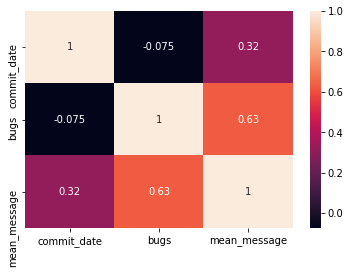

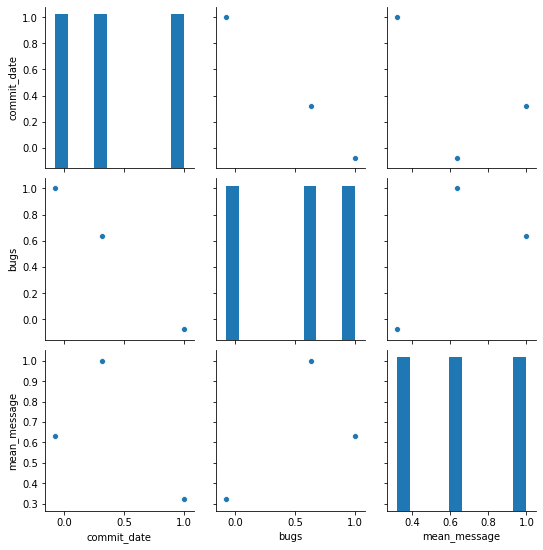

In [87]:
result_data = pd.read_csv("train.csv")
train = prepare(result_data)

In [88]:
train[200:210] # примерный вид данных, с которыми мы дальше работаем

,bugs,main_data,mean_message
200,3,"[38, 180, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0.9053334...",21.8
201,0,"[11, 334, 41, 134, 0, 0, 0, 0, 0, 0, 7, 0.8954...",52.0
202,3,"[38, 180, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0.8946210...",21.8
203,2,"[275, 215, 195, 268, 333, 0, 0, 0, 0, 0, 7, 0....",128.6
204,3,"[38, 180, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0.8135207...",21.8
205,4,"[45, 47, 9, 328, 388, 0, 0, 0, 0, 0, 7, 0.8029...",81.7
206,3,"[38, 180, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0.7686005...",21.8
207,0,"[133, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0.76345221...",13.3
208,3,"[12, 320, 357, 106, 130, 0, 0, 0, 0, 0, 0, 0.6...",92.5
209,2,"[12, 66, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0.6748446...",11.0


In [89]:
# разделение данных на тестовую и тренировочную части и преобразование в массив numpy для передачи на вход модели
# массив numpy выбран не случайно, потому что он массивы numpy работают быстрее, так как написаны на С++
X_train, X_test, y_train, y_test = train_test_split(train.drop(["bugs"], axis=1),
                                                    train['bugs'],
                                                    test_size=0.3)

tmp = []
for i in X_train.index.tolist():
    tmp.append(X_train["main_data"][i])

tmp_test = []
for i in X_test.index.tolist():
    tmp_test.append(X_test["main_data"][i])

tmp = np.array(tmp)
tmp_test = np.array(tmp_test)

tmp, tmp_test

(array([[3.13000000e+02, 8.80000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 9.67747621e-01],
        [2.11000000e+02, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.00000000e+00, 6.33078165e-01],
        [2.56000000e+02, 5.90000000e+01, 4.30000000e+01, ...,
         0.00000000e+00, 4.00000000e+00, 1.23262622e-01],
        ...,
        [2.24000000e+02, 6.70000000e+01, 1.31000000e+02, ...,
         0.00000000e+00, 5.00000000e+00, 3.44523218e-01],
        [4.25000000e+02, 4.29000000e+02, 5.24000000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 7.81750956e-01],
        [2.19000000e+02, 2.73000000e+02, 0.00000000e+00, ...,
         0.00000000e+00, 5.00000000e+00, 3.85633867e-01]]),
 array([[1.50000000e+02, 3.82000000e+02, 2.50000000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 1.04675494e-02],
        [8.60000000e+01, 1.42000000e+02, 2.53000000e+02, ...,
         0.00000000e+00, 0.00000000e+00, 1.11998511e-02],
        [1.92000000e+02, 

In [75]:
X_train

,main_data,mean_message
283,"[11, 238, 162, 0, 0, 0, 0, 0, 0, 0, 8, 0.33170...",41.1
161,"[589, 420, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0.249842...",100.9
151,"[168, 170, 141, 0, 0, 0, 0, 0, 0, 0, 5, 0.3021...",47.9
210,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6158682319...",0.0
274,"[11, 247, 318, 0, 0, 0, 0, 0, 0, 0, 5, 0.41718...",57.6
...,...,...
7,"[632, 443, 468, 504, 0, 0, 0, 0, 0, 0, 0, 0.97...",204.7
223,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0.8521678974...",0.0
265,"[177, 84, 383, 21, 321, 0, 0, 0, 0, 0, 0, 0.48...",98.6
278,"[40, 13, 355, 0, 0, 0, 0, 0, 0, 0, 5, 0.375849...",40.8


In [76]:
y_train = np.array(y_train)

In [77]:
train

,bugs,main_data,mean_message
0,4,"[552, 604, 592, 197, 0, 0, 0, 0, 0, 0, 0, 1.0, 2]",194.5
1,3,"[197, 419, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0.9988...",72.6
2,4,"[443, 642, 569, 546, 0, 0, 0, 0, 0, 0, 0, 0.98...",220.0
3,3,"[417, 581, 674, 0, 0, 0, 0, 0, 0, 0, 0, 0.9879...",167.2
4,7,"[529, 525, 503, 516, 444, 557, 581, 636, 471, ...",476.2
...,...,...,...
314,1,"[324, 164, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0.155586...",48.8
315,2,"[161, 86, 100, 0, 0, 0, 0, 0, 0, 0, 4, 0.15541...",34.7
316,3,"[370, 254, 259, 324, 0, 0, 0, 0, 0, 0, 4, 0.15...",120.7
317,1,"[12, 361, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0.1549086...",37.3


In [80]:
# подключаем для более удобного вывода
cb = TQDMNotebookCallback()
setattr(cb,'on_train_batch_begin',lambda x,y:None)
setattr(cb,'on_train_batch_end',lambda x,y:None)

In [92]:
# создаем модель для обучения
# были перебраны варианты без дропаута и с меньшим количеством слоев
# но они переобучались и давали слишком большую ошибку
# метрика MAE и MSE выбраны, потому что это задача регрессии, а не классификации
def create_model():
    model = models.Sequential()
    model.add(Dense(64, input_shape=(12,)))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(64))
    model.add(Dropout(0.5))
    model.add(Dense(64))
    model.add(Dense(64))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mse',
                  optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['mae'])
    return model


Variable 1 trained



Variable 2 trained



Variable 3 trained



Variable 4 trained



Variable 5 trained



Variable 6 trained



Variable 7 trained



Variable 8 trained



Variable 9 trained



Variable 10 trained
3.2689790061751447


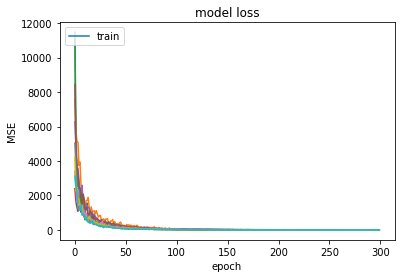

In [93]:
# историю обучение модели записываем в массив для построения графиков
# для наглядности я беру 10 необученных моделей и обучаю их на тренировочных данных
# после обучения всех я нахожу среднее MSE всех моделей для того, чтобы определить устойчивая ли это модель
exam = []
hist = []
for i in range(10):
    model = create_model()
    print("Variable %d training" % (i + 1))
    hist.append(model.fit(tmp,
                        y_train,
                        epochs=300,
                        verbose=0,
                        callbacks = [cb]))
    y_pred = model.predict(tmp_test)
    exam.append(mean_squared_error(y_test, y_pred))
    
print(sum(exam) / len(exam))

# построение графиков обучения моделей для наглядности (:
for i in hist:
    plt.plot(i.history['loss'])
    plt.title('model loss')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
plt.show()

In [99]:
# сохранение модели для дальнейшего использования и дообучения
model.save("model.h5")